# Introducción
Un banco comercial ha solicitado un modelo que pueda prever la salida de sus clientes. El banco ha informado que es más costoso atraer nuevos clientes que conservar a los nuevos, por lo que ha solicitado un modelo de la mayor calidad posible, conforme a la métrica F1, para poder identificar a los clientes que podrían abandonar sus servicios.

# Objetivo

Obtener al menos un valor F1 igual a 0.59 y compararlo con la métrica AUC-ROC para el conjunto de datos presente con ayuda de herramientas de machine learning en el lenguaje Phyton.

# Índice


- [1. Carga de los recursos necesarios](#1)
     - [1.1 Carga de librerías](#1.1)
     - [1.2 Carga de los datos](#1.2)
- [2. Análisis exploratorio](#2)
    - [2.1 Presetación preliminar](#2.1)
    - [2.2 Evaluación y corrección de la integridad y calidad de los datos](#2.2)
- [3. Segmentación, tratamiento y preparación del marco de datos para el modelo](#3)
    - [3.1 Segmentación de los datos entre características y objetivo](#3.1)
    - [3.2 Segmentación de los datos en conjuntos de entrenamiento, validación y prueba](#3.2)
    - [3.3 Tratamiento del desequilibrio de clases](#3.3)
    - [3.4 Apliación de One Hot Encoder a columnas `Gender` & `Geography`](#3.4)
    - [3.5 Escalar características numéricas](#3.5)
- [4. Aplicación de los modelos](#4)
    - [4.1 Bosque Aleatorio](#4.1)
    - [4.2 Regresión Logística](#4.2)
    - [4.3 Resumen de resultados](#4.3)
- [5. Conclusiones](#5)

# Cuerpo

## Carga de los recursos necesarios

### Carga de las librerías

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Para la segmentación de datos.
from sklearn.preprocessing import OneHotEncoder # Para la codificación de etiquetas.
from sklearn.utils import shuffle #Para barajear nuestro conjunto de datos.
from sklearn.preprocessing import StandardScaler # Para estandarizar las columnas numéricas.
from sklearn.model_selection import GridSearchCV # Para hacer modelos con distintos hiperparámetros.
from sklearn.ensemble import RandomForestClassifier # Modelo bosque aleatorio
from sklearn.linear_model import LogisticRegression #Modelo regresión Logística
from sklearn.linear_model import Ridge # Modelo Regresión Lineal con regularización l2
from sklearn.metrics import f1_score, confusion_matrix #Calculador del f1 y matriz de confusión
from sklearn.metrics import recall_score # Caclular valor de recall
from sklearn.metrics import roc_auc_score # Calculador del AUC_ROC
from sklearn.metrics import roc_curve # Obtener valores para cruva Roc
import matplotlib.pyplot as plt # Para poder trazar la curva. 

### Carga de los datos

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

## Análisis exploratorio

### Presentación preliminar

La empresa compartido las características de cada una de las columnas de los datos:

**Características:**

- `RowNumber`: índice de cadenas de datos
- `CustomerId`: identificador de cliente único
- `Surname`: apellido
- `CreditScore`: valor de crédito
- `Geography`:país de residencia
- `Gender`: sexo
- `Age`: edad
- `Tenure`: periododurante el cual ha madurado el depósito a plazo fijo de un cliente (años).
- `Balance`: Saldo de la cuenta
- `numOfProducts`: número de productos bancarios utilizados.
- `HasCrCard`: el cliente tiene una tarjeta de crédito (1 - sí: 0 - no)
- `IsActiveMember`: activida del cliente (1 - sí; 0 - no)
- `EstimatedSalary`: salario estimado

**Objetivo:**

- `Exited`:el cliente se ha ido (1 - sí; 0 - no)


### Evaualción de la integridad y calidad de los datos

In [3]:
# Descripción general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# Presencia de datos nulos
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
# Presencia de duplicados
df.duplicated().sum()

0

In [6]:
# Evaluar integridad de los datos.
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Observaciones generales:**
- Las columnas parecen tener el tipo de datos correcto o funcional.
- No hay presencia de datos duplicados.
- No hay datos cuyos valores sean imposibles como ingresos negativos, edades de 150 años, o más de tres tipos de valores en las características dicotómicas.

**Observación particular:**
- La variable objetivo con valor de 1 sólo representa el 20.37% del total. Dado que se nos solicita aprender de las características de las personas que han habandonado los servicios de Beta Bank y dado que sólo contamos con 10.000 datos totales, tratamientos de balanceo serán recomendables. De no hacerlo, el valor F1 obtenido para el conjunto de entrenamiento podría ser muy bueno pero en los demás conjuntos caería drásticamente.

**Correcciones y recomendaciones:**
- La columna `Tenure` no está completa. Le falta un 9.09% de valores con respecto a las demás tablas. En este caso, la pérdida de datos no es demasiada por lo que puede ser fácilmente completada por su media o, en dado caso de que esta esté demasiado alejada a causa de valores atípicos, por su mediana.

In [7]:
# Observar la media y la mediana de mi distribución.
df['Tenure'].mean(), df['Tenure'].median()

(4.997690023099769, 5.0)

Ambas son muy similares por lo que, en pos de conservar el número entero, podemos imputar fácilmente por su mediana de 5. 

In [8]:
# Imputar datos con base en la mediana.
df.loc[df['Tenure'].isna(), 'Tenure'] = 5

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Segmentación de los datos y tratamiento del desbalance de clases

### Segmentación de los datos entre características y objetivo. 

Para preparar el modelo debemos separar nuestro objetivo del resto de las columnas. Sin embargo, previamente se puede decidir qué características formarán parte del modelo y cómo será procesada cada columna.

**Columnas que no se integrarán para el entrenamiento del modelo:**

`RowNumber` se descartará pues no es necesaria para el modelo.
`CustomerId` tampoco será necesario para el modelo, pero podemos conservarlo (al menos hasta antes de entrenar el modelo) para corroborar que las modificaciones se apliquen correctamente en cada fila.
`Surname` se descartará puesto que, en términos prácticos, no buscamos determinar si el apellido está relacionado de alguna forma con las salidas de los clientes.

**Columnas numéricas:**

`Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary`. Es necesario escalar estas variables.

**Columnas categóricas:**

`Geography`, `Gender`. Dado que la librería de sklearn no acepta variables categóricas sin procesar, serán necearios ciertos pasos previos. Para modelos no basados en árboles y en dado caso que no tengamos demasiadas categorías por columna, el mejor método será One Hot Encoder. Para modelos basados en árboles, también podemos probar este método pero si no alcanza el objetivo mínimo, tal vez sea necesario compararlo con el método alternativo de codificación de etiquetas. 

**Características dicotómicas:**

`HasCrCard`, `IsActiveMember`. Las conservaremos en su forma entera, sin escalar. 

In [10]:
# Segmentar nuestro conjunto de datos en características y en variable objetivo.
x = df.drop(['RowNumber','Surname','Exited'], axis = 1)
y = df['Exited']

Por un lado, podemos usar el método One Hot Encoder en `Gender` y en `Geography` ya que no se trata de variables ordinales. Por otro, es necesario saber si las categorías de cada columna son pocas. Si son demasiadas, podría ser que aplicar codificación de etiquetas sea más viable.

In [11]:
# Analizar la factibilidad de usar OneHotEncoder con variable
x.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [12]:
# Analizar la factibilidad de usar OneHotEncoder con columna `Geography`
x.Geography.unique()


array(['France', 'Spain', 'Germany'], dtype=object)

Los géneros y los países son relativamente pocos por lo que no se esperan problemas de multidimensionalidad al usar el método One Hot Encoder. 

### Segmentación de datos en conjunto de entrenamiento(train), validación(valid), y prueba(test).

Dado que se considera que no habrá un posterior conjunto de prueba, se dividirá el marco de datos en una proporcion de 3:1:1. Es decir, 60% para el conjunto de entrenamiento, 20% para el conjunto de validación y 20% para el conjunto de prueba final sobre el cual intentaremos maximizar F1. 

In [13]:
# Crear los conjuntos de datos
##Conjunto de entrenamiento y el 40% restante del marco
x_train, x_40, y_train, y_40 = train_test_split(x, y, random_state = 73, test_size =.40, shuffle = True) 
##Conjunto de validación y de prueba.
x_valid, x_test, y_valid, y_test = train_test_split(x_40, y_40, random_state = 73, test_size = .50, shuffle = True)

In [14]:
x_train.shape, x_40.shape, y_train.shape, y_40.shape, x_valid.shape, x_test.shape, y_valid.shape, y_test.shape

((6000, 11),
 (4000, 11),
 (6000,),
 (4000,),
 (2000, 11),
 (2000, 11),
 (2000,),
 (2000,))

### Tratamiento del desequilibrio de clases.

Se mencionó que nuestra variable objetivo sólo representaba alrededor del 20% del total. Ello podría causar que nuestro modelo no aprenda lo suficiente de los casos de abandono que se intentan explicar. Para remediar esto, y tomando en cuenta que nuestro conjunto de entrenamiento sólo contiene 6.000 instancias, se recurre a la técnica de sobremuestreo. Si se duplica el número de observaciones positivas a (aproximadamente) 2.400, tendremos una proporción de 1:2 con 4.800 instancias negativas. Podemos terminar de resolver el desbalance ajustando un hiperparámetro en cada modelo. En caso de que el objetivo mínimo no sea alcanzado se recurrirá a modificar el umbral de los modelos.

In [15]:
# Dividir el conjunto de entrenamiento en clases positivas y negativas (objetivos de cero y uno)
x_train_ceros = x_train[y_train == 0]
x_train_unos = x_train[y_train == 1]
y_train_ceros = y_train[y_train == 0]
y_train_unos = y_train[y_train == 1]

In [16]:
# Concatenar las tablas para tener nuestro nuevo conjunto de entrenamiento.
x_train_up = pd.concat([x_train_ceros] + [x_train_unos] * 2)
y_train_up = pd.concat([y_train_ceros] + [y_train_unos] * 2)

In [17]:
# Comprobar que tienen mismo número de filas.
x_train_up.shape, y_train_up.shape

((7217, 11), (7217,))

In [18]:
x_train_up.head(3)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1558,15618018,571,France,Female,35,1.0,104783.81,2,0,1,178512.52
7934,15803886,629,Spain,Male,31,6.0,132876.55,1,1,1,130862.11
5951,15590637,721,France,Male,41,7.0,0.00,2,0,1,61018.85


Sin embargo, es necesario barajear las columnas para que el modelo aprenda correctamente.

In [19]:
# Barajear los conjuntos
x_train_up, y_train_up = shuffle(x_train_up, y_train_up, random_state = 73) 

In [20]:
x_train_up.head(3)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2885,15716024,660,Spain,Male,42,5.0,0.0,2,1,0,115509.59
6836,15591344,715,Spain,Male,42,6.0,0.0,2,1,1,128745.69
3619,15715939,730,France,Male,33,0.0,0.0,2,1,0,1474.79


### Aplicación de One Hot Encoder a columnas `Gender` & `Geography`.

Para estas dos columnas podemos aplicar el método de One Hot Encoder.

In [21]:
#Crear instancia
ohe = OneHotEncoder(sparse = False, drop = 'first')
#Crear nuevas columnas y nombrarlas
ohe_ambas = pd.DataFrame(ohe.fit_transform(x_train_up[['Gender', 'Geography']]), columns = ['Male', 'Germany', 'Spain'])
#Concatenar los resultados
x_train_ohe = pd.concat([x_train_up.drop(columns = ['Gender','Geography']).reset_index(drop=True), ohe_ambas], axis = 1)
# Mostrar el nuevo DataFrame
x_train_ohe.head(3)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,15716024,660,42,5.0,0.0,2,1,0,115509.59,1.0,0.0,1.0
1,15591344,715,42,6.0,0.0,2,1,1,128745.69,1.0,0.0,1.0
2,15715939,730,33,0.0,0.0,2,1,0,1474.79,1.0,0.0,0.0


Aplicamos el mismo método a el conjunto de prueba y de validación

In [22]:
#Para el conjunto de validación
nombres = ['Male', 'Germany', 'Spain']
ohe_ambas_valid = pd.DataFrame(ohe.transform(x_valid[['Gender', 'Geography']]), columns = ['Male', 'Germany', 'Spain'])

x_valid_ohe = pd.concat([x_valid.drop(columns = ['Gender', 'Geography']).reset_index(drop=True), ohe_ambas_valid], axis = 1)

x_valid_ohe.head(3)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,15667602,704,33,3.0,0.0,2,1,0,73018.74,1.0,0.0,1.0
1,15811877,700,36,4.0,0.0,2,1,0,130789.15,0.0,0.0,0.0
2,15575486,529,27,1.0,0.0,2,1,1,37769.98,0.0,0.0,0.0


In [23]:
#Para el conjunto de prueba
ohe_ambas_test = pd.DataFrame(ohe.transform(x_test[['Gender', 'Geography']]), columns = ['Male', 'Germany', 'Spain'])

x_test_ohe = pd.concat([x_test.drop(columns = ['Gender', 'Geography']).reset_index(drop=True), ohe_ambas_test], axis = 1)

x_test_ohe.head(3)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,15647266,651,45,5.0,135923.16,1,1,0,18732.84,0.0,0.0,1.0
1,15722731,653,46,0.0,119556.10,1,1,0,78250.13,1.0,0.0,0.0
2,15598157,728,34,4.0,106328.08,1,1,0,88680.65,1.0,0.0,0.0


### Escalar características numéricas.

In [24]:
#Crear instancia
ss = StandardScaler()
numericas = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
x_train_ohe[numericas] = ss.fit_transform(x_train_ohe[numericas])

In [25]:
x_train_ohe.head(3)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,15716024,0.097934,0.192222,0.018805,-1.278235,0.754808,1,0,0.273355,1.0,0.0,1.0
1,15591344,0.666016,0.192222,0.380712,-1.278235,0.754808,1,1,0.501802,1.0,0.0,1.0
2,15715939,0.820948,-0.658747,-1.790728,-1.278235,0.754808,1,0,-1.694821,1.0,0.0,0.0


In [26]:
# Aplicar transform a conjunto de validación
x_valid_ohe[numericas] = ss.transform(x_valid_ohe[numericas])
x_valid_ohe.head(3)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,15667602,0.552400,-0.658747,-0.705008,-1.278235,0.754808,1,0,-0.460013,1.0,0.0,1.0
1,15811877,0.511085,-0.375091,-0.343102,-1.278235,0.754808,1,0,0.537071,0.0,0.0,0.0
2,15575486,-1.255136,-1.226060,-1.428822,-1.278235,0.754808,1,1,-1.068386,0.0,0.0,0.0


In [27]:
#Aplicar transform a conjunto prueba
x_test_ohe[numericas] = ss.transform(x_test_ohe[numericas])
x_test_ohe.head(3)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,15647266,0.004975,0.475879,0.018805,0.920051,-0.845971,1,0,-1.396957,0.0,0.0,1.0
1,15722731,0.025632,0.570431,-1.790728,0.655346,-0.845971,1,0,-0.369722,1.0,0.0,0.0
2,15598157,0.800290,-0.564195,-0.343102,0.441410,-0.845971,1,0,-0.189697,1.0,0.0,0.0


Por último, ya que hemos garantizado que los valores corresponden correctamente con su ID, debemos eliminar esta columna categórica para que los modelos no tengan problemas.

In [28]:
# Eliminar CustomerID de todos nuestros conjuntos de características
X_train = x_train_ohe.drop('CustomerId', axis = 1)
X_valid = x_valid_ohe.drop('CustomerId', axis = 1)
X_test = x_test_ohe.drop('CustomerId', axis = 1)
X_train.shape, X_valid.shape, X_test.shape

((7217, 11), (2000, 11), (2000, 11))

## Aplicación de los modelos

Nos centraremos en los siguientes tres modelos: Árbol de Decisión, Regresión Logísica y Regresión Lineal.

### Bosque Aleatorio

In [29]:
# Crear instancias de cada modelo a utilizar
bosque = RandomForestClassifier(random_state = 73)
# Crear directorio de los valores a combinar
hip_bosque = {'n_estimators':[1,2,5,10,40,60,80], 'max_depth':[35,45,55], 'class_weight': ['balanced', None]} # Solicitamos un bosque de 1 árbol
#Crear parrilla de elementos
gs_bosque = GridSearchCV(bosque, hip_bosque, cv=5, scoring = 'f1')
# Entrenar el modelo con conjunto de entrenamiento
best_bosque = gs_bosque.fit(X_train, y_train_up)
#Mostrar los hiperparámetros del mejor modelo
best_bosque.best_params_, best_bosque.best_score_

({'class_weight': None, 'max_depth': 35, 'n_estimators': 80},
 0.8924867243961219)

Nótese que, a pesar de que se esperaba que el parámetro `class_weight` resultase balanceado, GridSearchCV encontró que funciona mucho mejor cuando es None. 

In [30]:
# Evaluar F1 en conjunto de validación
valid_bosque = best_bosque.predict(X_valid)
f1_bv = f1_score(y_valid, valid_bosque)
f1_bv

0.6065573770491803

In [31]:
#Evaluar en conjunto de prueba
test_bosque = best_bosque.predict(X_test)
f1_bt = f1_score(y_test, test_bosque)
f1_bt

0.6130374479889044

In [32]:
# Calculo AUC_ROC bosque con conjunto de validación.
ar_bv = roc_auc_score(y_valid, best_bosque.predict_proba(X_valid)[:,1])
# Calculo AUC ROC bosque con conjunto de prueba.
ar_bt = roc_auc_score(y_test, best_bosque.predict_proba(X_test)[:,1])

In [33]:
#Matriz de confusión conjutno de validación
confusion_matrix(y_valid, valid_bosque)

array([[1490,  102],
       [ 186,  222]])

In [34]:
#Matriz de confusión conjunto de prueba
confusion_matrix(y_test, test_bosque)

array([[1500,   88],
       [ 191,  221]])

Los valores obtenidos con el bosque aleatorio cumplen, para cada conjunto, con un F1 superio a 0.59. A su vez, ya que se solicitó un Bosque Aleatorio de un árbol, se descarta que un modelo de Árbol de Decisión haya superado los valores actuales. 

### Regresión Logística

In [35]:
reglos = LogisticRegression(random_state = 73, solver = 'liblinear', multi_class = 'auto')
hip_reglos = {'penalty': ['l1','l2'], 'fit_intercept': [True, False], 'class_weight': ['balanced', None], 'warm_start':[False,True]}
gs_reglos = GridSearchCV(reglos, hip_reglos, cv=5, scoring = 'f1')
best_reglos = gs_reglos.fit(X_train, y_train_up)
best_reglos.best_params_, best_reglos.best_score_

({'class_weight': 'balanced',
  'fit_intercept': True,
  'penalty': 'l1',
  'warm_start': False},
 0.6174897620846215)

In [36]:
#Evaluar f1 en conjunto de valdiación
valid_reglos = best_reglos.predict(X_valid)
f1_lv = f1_score(y_valid, valid_reglos)
f1_lv

0.49380530973451325

In [37]:
# Cálculo AUC ROC Regresión Logística conjunto de valdiación
ar_lv = roc_auc_score(y_valid, best_reglos.predict_proba(X_valid)[:,1]).round(3)

In [38]:
#Evaluar f1 en conjunto de prueba
test_reglos = best_reglos.predict(X_test)
f1_lt = f1_score(y_test, test_reglos)
f1_lt

0.4905008635578584

In [39]:
ar_lt = roc_auc_score(y_test, best_reglos.predict_proba(X_test)[:,1]).round(3)

El valor F1 para el conjunto de prueba alcanzó el F1 mínimo, sin embargo, al aplicarlo a los demás conjuntos, los valores son muy bajos (incluso con el hiperparámetro "balanced"). Para intetar mejorar su predicción, se puede modificar el umbral de decisión. 

#### Cambio del umbral de clasificación

Para encontrar el valor que maximice el valor F1, modificando el umbral de decisión, podemos recurrir a un proceso iterativo para nuestros datos de validación y de prueba. A su vez, podemos calcular la curva ROC (del inglés característica operativa del receptor) que coloca la Tasa de Falsos Positivos en el eje "x" y la Tasa de Verdaderos Positivos en "y".

In [40]:
# Umbral modificado para el conjunto de validación
valid_reglos_proba = best_reglos.predict_proba(X_valid)
reglos_one_valid = valid_reglos_proba[:,1]

for umbral in np.arange(.5, .6, 0.01):
    predicted_valid = reglos_one_valid > umbral
    f1_umbral_valid = f1_score(y_valid, predicted_valid)
    recall_valid = recall_score(y_valid, predicted_valid)
    
    print('Umbral = {:.2f} || f1 = {:.3f} || TVP ={:.3f}'.format(umbral, f1_umbral_valid, recall_valid))

Umbral = 0.50 || f1 = 0.494 || TVP =0.684
Umbral = 0.51 || f1 = 0.495 || TVP =0.672
Umbral = 0.52 || f1 = 0.496 || TVP =0.657
Umbral = 0.53 || f1 = 0.493 || TVP =0.640
Umbral = 0.54 || f1 = 0.497 || TVP =0.637
Umbral = 0.55 || f1 = 0.495 || TVP =0.618
Umbral = 0.56 || f1 = 0.491 || TVP =0.596
Umbral = 0.57 || f1 = 0.486 || TVP =0.578
Umbral = 0.58 || f1 = 0.480 || TVP =0.559
Umbral = 0.59 || f1 = 0.477 || TVP =0.544


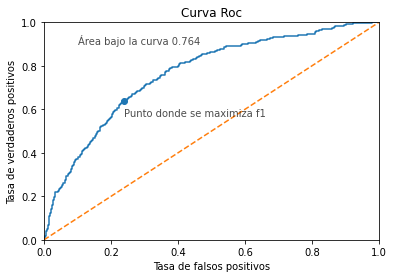

In [41]:
# Calcular curva ROC con el conjunto de validación

#Obtener los valores para trazar la curva.
fpr_valid, tpr_valid, threshold_valid = roc_curve(y_valid, reglos_one_valid)
# Comandos para el trazo
plt.figure()
plt.plot(fpr_valid, tpr_valid)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.scatter(.24,.637)
plt.text(.24, .57, 'Punto donde se maximiza f1', alpha = 0.7)
plt.text(.1,.9, f'Área bajo la curva {ar_lv}', alpha = 0.7)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva Roc')
plt.show()


In [42]:
# Umbral modificado para el conjunto de prueba.
test_reglos_proba = best_reglos.predict_proba(X_test)
reglos_one_test = test_reglos_proba[:,1]

for umbral in np.arange(.5, .6, 0.01):
    predicted_test = reglos_one_test > umbral
    f1_umbral_test = f1_score(y_test, predicted_test)
    recall_test = recall_score(y_test, predicted_test)
    print('Umbral = {:.2f} || f1 = {:.3f} || TVP = {:.3f}'.format(umbral, f1_umbral_test, recall_test))

Umbral = 0.50 || f1 = 0.491 || TVP = 0.689
Umbral = 0.51 || f1 = 0.495 || TVP = 0.680
Umbral = 0.52 || f1 = 0.495 || TVP = 0.663
Umbral = 0.53 || f1 = 0.497 || TVP = 0.648
Umbral = 0.54 || f1 = 0.501 || TVP = 0.636
Umbral = 0.55 || f1 = 0.493 || TVP = 0.612
Umbral = 0.56 || f1 = 0.499 || TVP = 0.602
Umbral = 0.57 || f1 = 0.502 || TVP = 0.592
Umbral = 0.58 || f1 = 0.499 || TVP = 0.580
Umbral = 0.59 || f1 = 0.496 || TVP = 0.561


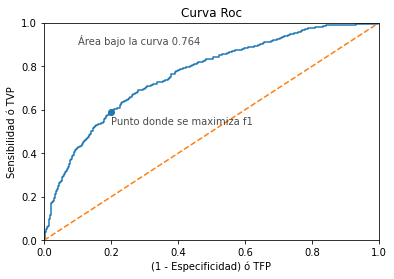

In [43]:
#Obtener los valores para trazar la curva ROC con conjunto de prueba.
fpr_test, tpr_test, threshold_test = roc_curve(y_test, reglos_one_test)
# Comandos para el trazo
plt.figure()
plt.plot(fpr_test, tpr_test)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.scatter(.2,.592)
plt.text(.2, .53, 'Punto donde se maximiza f1', alpha = 0.7)
plt.text(.1,.9, f'Área bajo la curva {ar_lv}', alpha = 0.7)
plt.ylabel('Sensibilidad ó TVP')
plt.xlabel('(1 - Especificidad) ó TFP')
plt.title('Curva Roc')
plt.show()


Como se observa, incluso al modificar el umbral y maximizar f1 en ambos conjuntos de datos, se está muy lejos de alcanzar el valor mínimo aceptable. Sin embargo, se realizan otras observaciones interesantes para ambos conjuntos:

- La curva ROC tiene valores marginales decrecientes: recordemos que los valores TFP altos son indeseables en comparación con valores más grandes de TVP que sí buscamos aumentar. No es casualdiad que el valor f1 máximo se alcance cerca de donde parezca obtenerse una pendiente unitaria de la línea tangente a ese punto. 

- El mayor problema del modelo radica en el gran número de Falsos Positivos: es por esto que f1 mejoró con un umbral por sobre 0.5, pues ello implica que está disminuyendo la cantidad de valores 1 en el modelo. En términos relativos, el alto valor de recall permite, sin mayor problema, una caída de los Verdaderos Positivos en pos de rescatar el valor de precisión que tanto adolece y que tanto desangra a f1. Lo anterior se puede observar mejor revisando sus respectivas matrices de confusión.

In [44]:
#Matriz confusión conjunto validación
confusion_matrix(y_valid, valid_reglos)

array([[1149,  443],
       [ 129,  279]])

In [45]:
#Matriz de confusión conjunto de prueba
confusion_matrix(y_test, test_reglos)

array([[1126,  462],
       [ 128,  284]])

Como se observa, los Falsos Positivos representan alrededor del 77.5% de los errores para cada modelo. Sin embargo, es necesario advertir que en términos matemáticos f1 se reduce por un valor relativamente bajo de precisión en comparación con su valor de sensibilidad, pero ello no implica que para la empresa sea mejor concentrar sus esfuerzos en mejorar aquél por sobre éste.  

### Resumen de resultados

He aquí lo encontrado:

In [46]:
# DataFrame con los resultados
marco = ([best_bosque.best_score_, f1_bv,ar_bv,f1_bt,ar_bt],
        [best_reglos.best_score_, f1_lv,ar_lv,f1_lt,ar_lt])
columnas = ['F1 train', 'F1 valid','AUC ROC', 'F1 test', 'AUC ROC']

resumen = pd.DataFrame(marco, columns = columnas, index = ['Bosque Aleatorio', 'Regresión Logística']).round(3)

In [47]:
resumen

,F1 train,F1 valid,AUC ROC,F1 test,AUC ROC
Bosque Aleatorio,0.892,0.607,0.836,0.613,0.837
Regresión Logística,0.617,0.494,0.764,0.491,0.764


En definitiva, el modelo que se recomienda en este caso es el de Bosque Aleatorio pues cumple con nuestro objetivo mínimo de un valor F1 de 0.59. Sin embargo, debe señalarse que es apenas mayor al objetivo y que el modelo inicial tiende a hacer sobreajuste. El modelo de Regresión Logística también tuvo cierto grado de sobreajuste pero no cumplió con los requerimientos para ningún conjunto de datos.

Los valores del área bajo la curva de la Característica Operativa del Receptor (en tabla como AUC ROC) también son mayores para el modelo de Bosque Aleatorio. Este valor, cuyo rango va de 0 a 1, ayuda a comparar la calidad del modelo contra una simple asiganción aleatoria (en cuyo caso AUC ROC sería 0.5), de tal forma que su calidad es mejor cuanto más se acerque a la unidad.


## Conclusiones

Se analizaron los datos compartidos por la banca privada Beta Bank con respecto a las características de sus clientes con el fin de determinar un modelo mediante Machine Learning que previere la salida de los mismos. El marco de datos, aunque relativamente pequeño estaba completo casi en su totalidad. Sin embargo, nuestra clase positiva representaba sólo alrededor del 20% de nuestras observaciones por lo que fue necesario balancear las clases. A su vez, se utilizó la metodología de codificaciíon de etiquetas (One Hot Encoder) para las variables categóricas y se estandarizaron las varariables numéricas. Si bien, OHE no es muy recomendable para los modelos basados en árboles, en este caso funcionó mejor el modelo de Bosque Aleatorio que el modelo de Regresión Logística. Se consideró realizado el modelo de Árbol de Decisión cuando se especificó un Bosque Aleatorio de 1 árbol.

El modelo de Bosque Aleatorio superó, para cada conjunto de datos, el valor mínimo objetivo de 0.59. Si bien lo hizo ligeramente, la métrica de AUC ROC también fue muy suprior para este modelo que para el modelo de Regresión lineal. 